In [153]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import matplotlib.gridspec as gridspec
import pickle
from itertools import product
import sklearn as sk



%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df = pp.load_session_db()
df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]
df= df[df['ImagingRegion'].str.match('CA1')|df['ImagingRegion'].str.match('')]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [12]:
basedir = "G:\\My Drive\\Figures\\TwoTower\\SingleSession\\"
def PC_list_maker(mlist,firstSess = None):
    FR_dict = {}
    FR_dict[0],FR_dict[1]={},{}
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    
    for i, (mouse,f_ind) in enumerate(zip(mlist,firstSess)): 

        df_mouse = df[df['MouseName'].str.match(mouse)]
        for mat_ind,sess_ind in enumerate(np.arange(f_ind,df_mouse.shape[0]).tolist()):
            print("session ind",sess_ind)
            
            sess = df_mouse.iloc[sess_ind]
            VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
            trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)

            S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
            S_trial_mat[np.isnan(S_trial_mat)]=0
            
            
            
            S_morph_dict = u.trial_type_dict(S_trial_mat,trial_info['morphs'])
            
            S_mu,l = u.across_trial_avg(S_trial_mat,trial_info['morphs'])
            if i==0 and mat_ind==0:
                MU = S_mu
               
            else:
                MU = np.concatenate((MU,S_mu),axis=-1)
                
            
            pc_file = os.path.join(basedir,mouse,"%s_%s_%i" % (sess['Track'],sess['DateFolder'],sess['SessionNumber']),'pc_masks.pkl')
            try:
                with open(pc_file,'rb') as f:
                    masks = pickle.load(f)['masks']
            except:
                masks, FR, SI = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                        VRDat['tstart']._values, VRDat['teleport']._values,
                        method='bootstrap',correct_only=False,speed=VRDat.speed._values,
                        win_trial_perm=True,morphlist=[0,1])
                with open(pc_file,'wb') as f:
                    pickle.dump({'masks':masks},f)
                
            fr_dict = pc.plot_placecells(S_morph_dict,masks,plot=False)
            
           
            for sort in [0,1]:
                for m in [0,.25,.5,.75,1.]:
                    if i==0 and mat_ind == 0:
                        
                        FR_dict[sort][m] = fr_dict[sort][m]
                    else:
                        FR_dict[sort][m]=np.concatenate((FR_dict[sort][m],fr_dict[sort][m]),axis=0)
    return FR_dict, MU

In [13]:
# load up place cells
Rare_dict, Rare_mu = PC_list_maker(['4139265.5','4139265.4','4139265.3','4222168.1'],firstSess=[5,5,5,3])
Fam_dict, Fam_mu=PC_list_maker(['4222153.2','4222153.3','4222153.1','4222174.1'],firstSess=4)

session ind 5
num aberrant ttls 0.0
34737 (34737,) (34737, 21) 113863
(113863,) (113863, 21)
frame diff 0
session ind 6
num aberrant ttls 0.0
36018 (36018,) (36018, 21) 118606
(118606,) (118606, 21)
frame diff 0
session ind 7
num aberrant ttls 0.0
40272 (40272,) (40272, 21) 133982
(133982,) (133982, 21)
frame diff 0
session ind 8
num aberrant ttls 0.0
36659 (36659,) (36659, 21) 120387
(120387,) (120387, 21)
frame diff 0
session ind 9
num aberrant ttls 0.0
36583 (36583,) (36583, 21) 124384
(124384,) (124384, 21)
frame diff 0
session ind 5
num aberrant ttls 0.0
30897 (30897,) (30897, 21) 102093
(102093,) (102093, 21)
frame diff 0
session ind 6
num aberrant ttls 0.0
29023 (29023,) (29023, 21) 95160
(95160,) (95160, 21)
frame diff 0
session ind 7
num aberrant ttls 0.0
31116 (31116,) (31116, 21) 102131
(102131,) (102131, 21)
frame diff 0
session ind 8
num aberrant ttls 0.0
31932 (31932,) (31932, 21) 105228
(105228,) (105228, 21)
frame diff 0
session ind 9
num aberrant ttls 0.0
30493 (30493,

In [ ]:
#define single session class that 

def load_session_data(sess,basedir = "G:\\My Drive\\Figures\\TwoTower\\SingleSession\\"):
    VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
    S/=1546
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
    effMorph = trial_info['morphs']+trial_info['wallJitter']+trial_info['bckgndJitter']#+.3)/1.6 

    S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
    S_trial_mat[np.isnan(S_trial_mat)]=0
    S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,2,axis=1)

    pc_file = os.path.join(basedir,mouse,"%s_%s_%i" % (sess['Track'],sess['DateFolder'],sess['SessionNumber']),'pc_masks.pkl')
    with open(pc_file,'rb') as f:
        masks = pickle.load(f)['masks']

    effMorph_sort = effMorph[np.argsort(effMorph)]
    S_trial_mat_sort = S_trial_mat[np.argsort(effMorph),:,:]
    morphs_sort = trial_info['morphs'][np.argsort(effMorph)]

    return S_trial_mat_sort, morphs_sort, effMorph_sort, masks

def make_masks(masks):
    return masks[0]*(~masks[1]),masks[1]*(~masks[0]),masks[0]*masks[1]

def bootstrap_rm(PCs_morph_rm):
    bs_rm = np.zeros(PCs_morph_rm.shape[1:])
    ntrials = PCs_morph_rm.shape[0]
    for i in range(20):
        inds = np.random.permutation(ntrials)
        inds = inds[:int(ntrials*.5)]
        bs_rm += PCs_morph_rm[inds,:,:].mean(axis=0)
    bs_rm/=20
    return bs_rm

In [456]:
# load single session
mouse = '4222168.1'
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse.iloc[-2]

S_trial_mat_sort, morphs_sort, effMorph_sort, masks = load_session_data(sess)
ex_mask0,ex_mask1,and_mask = make_masks(masks)

num aberrant ttls 0.0
35249 (35249,) (35249, 21) 99523
(99523,) (99523, 21)
frame diff 0


In [504]:
PCs_and = S_trial_mat_sort[:,:,and_mask]
PCs_and_0, PCs_and_1 = bootstrap_rm(PCs_and[morphssort==0,:,:]), bootstrap_rm(PCs_and[morphssort==1,:,:])
max_and_0,max_and_1=np.argmax(PCs_and_0,axis=0),np.argmax(PCs_and_1,axis=0)

same_mask = np.abs(max_and_0-max_and_1)<=2
or_mask = np.abs(max_and_0-max_and_1)>=10


inc_mask0 = np.copy(masks[0])
inc_mask0[and_mask] = np.copy(or_mask)

inc_mask1 = np.copy(masks[1])
inc_mask1[and_mask]=np.copy(or_mask)


(array([112.,  45.,  37.,  30.,  33.,  43.,  34.,  23.,  24.,  24.,  42.,
         22.,  24.,  24.,  11.,  20.,  12.,  18.,   5.,   8.]),
 array([ 0. ,  2.2,  4.4,  6.6,  8.8, 11. , 13.2, 15.4, 17.6, 19.8, 22. ,
        24.2, 26.4, 28.6, 30.8, 33. , 35.2, 37.4, 39.6, 41.8, 44. ]),
 <a list of 20 Patch objects>)

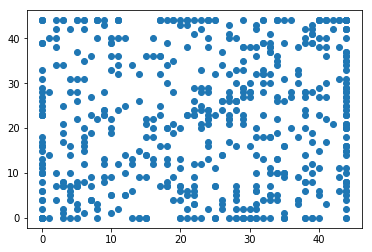

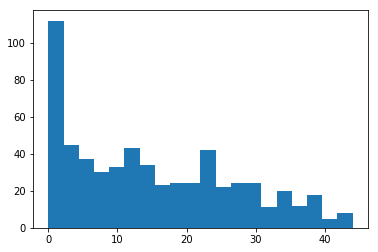

In [505]:
f,ax = plt.subplots()
ax.scatter(max_and_0,max_and_1)
f,ax = plt.subplots()
ax.hist(np.abs(max_and_0-max_and_1),bins=20)


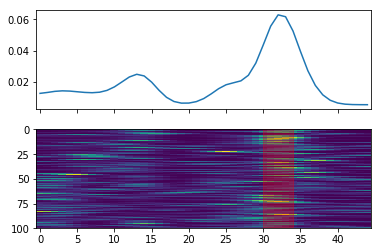

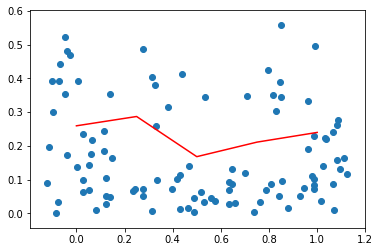

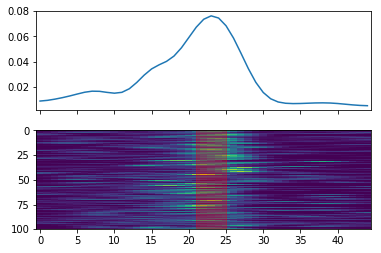

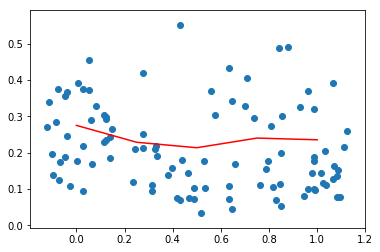

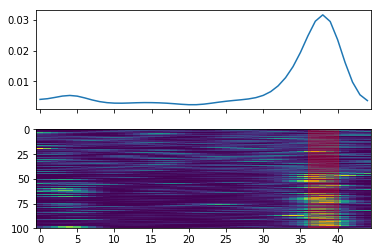

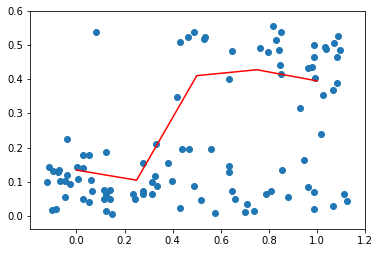

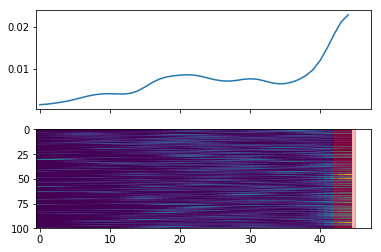

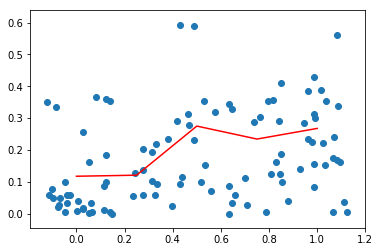

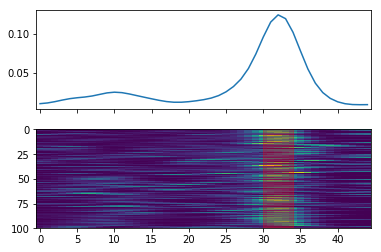

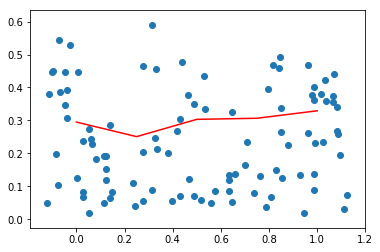

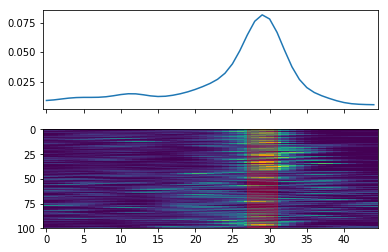

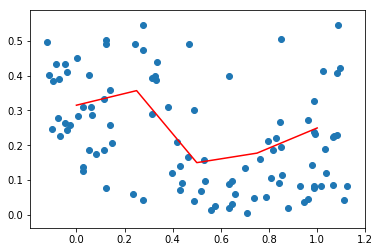

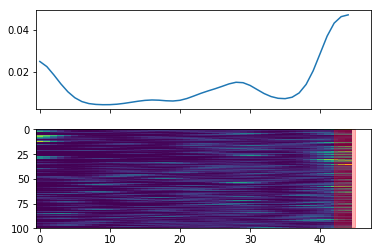

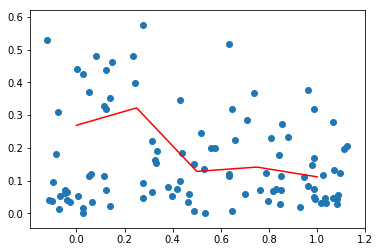

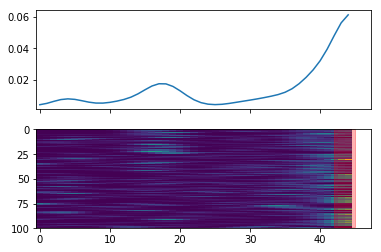

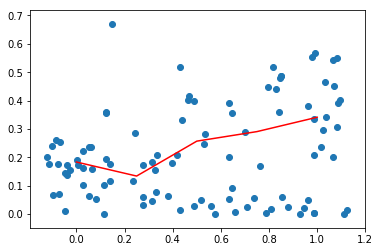

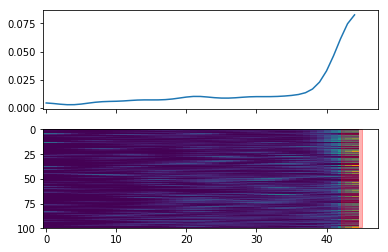

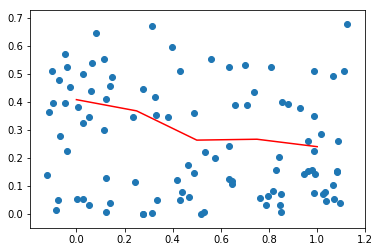

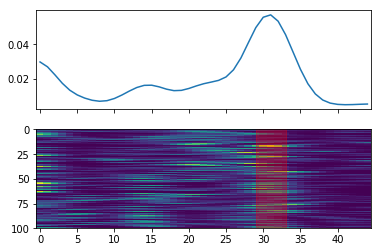

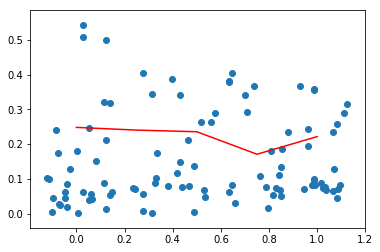

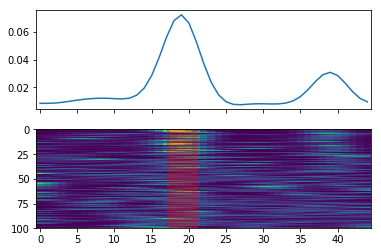

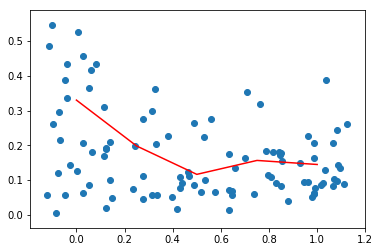

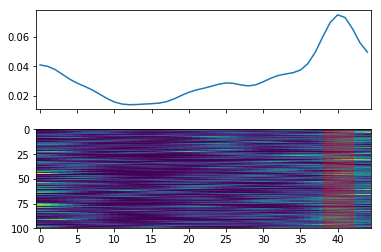

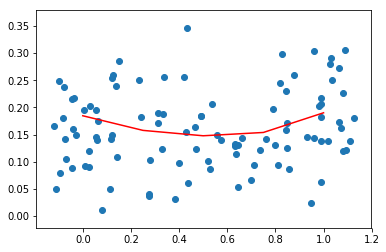

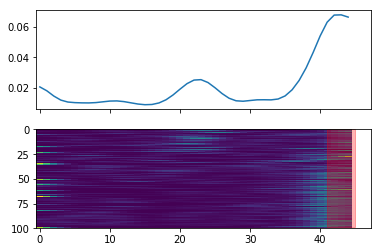

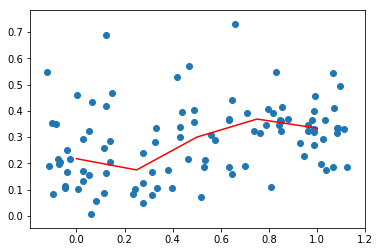

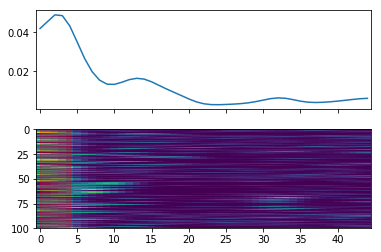

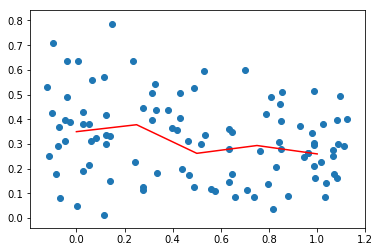

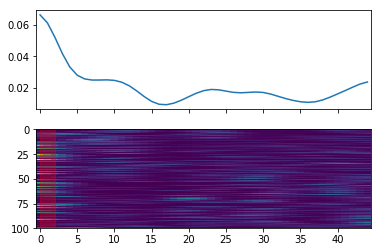

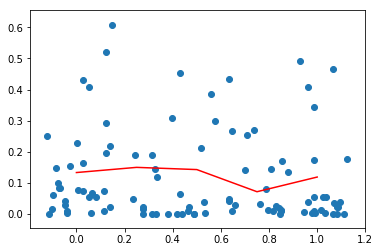

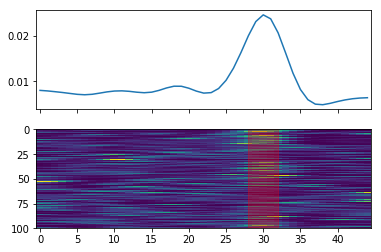

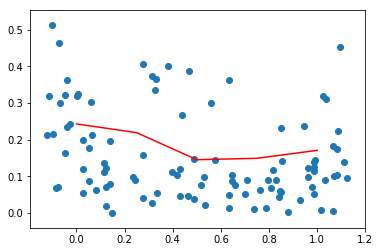

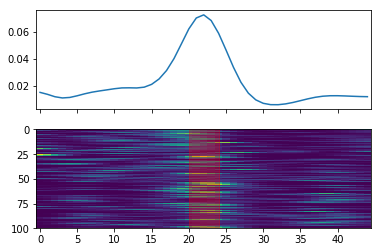

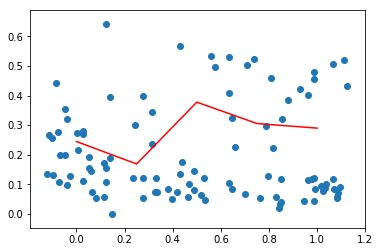

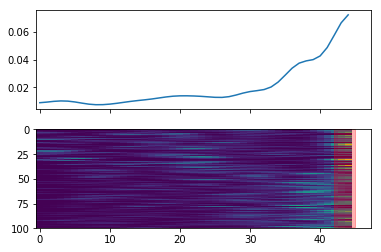

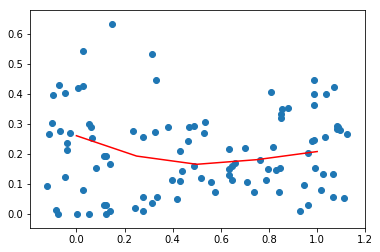

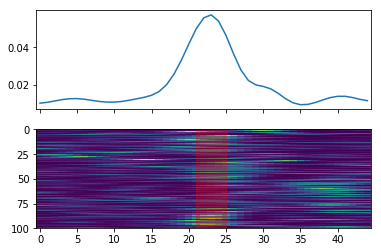

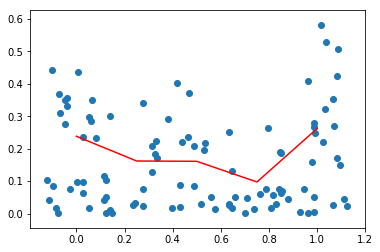

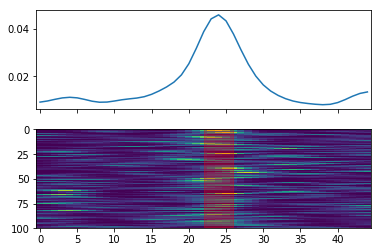

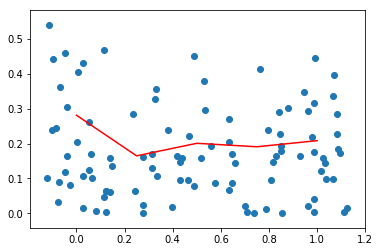

In [506]:
#same place field 

PCs_and_same = PCs_and[:,:,same_mask]
PCs_and_same_rm = bootstrap_rm(PCs_and_same[(morphssort==0) | (morphssort==1),:,:])

maxpos = np.argmax(PCs_and_same_rm,axis=0)
minb = np.maximum(0,maxpos-2)
maxb = np.minimum(45,maxpos+2)


avgMat,trsh = u.across_trial_avg(PCs_and_same,morphssort)
meanrates_same = np.zeros([PCs_and_same.shape[-1],5])
rates_same = np.zeros([PCs_and_same.shape[-1],S_trial_mat.shape[0]])
for c in range(PCs_and_same.shape[-1]):
    rates_same[c,:]=PCs_and_same[:,minb[c]:maxb[c],c].sum(axis=1)/(PCs_and_same[:,:,c].sum(axis=1))#-PCs_and_same[:,minb[c]:maxb[c],c].sum(axis=1))*39
    meanrates_same[c,:]=avgMat[:,minb[c]:maxb[c],c].sum(axis=1)/(avgMat[:,:,c].sum(axis=1)) #-avgMat[:,minb[c]:maxb[c],c].sum(axis=1))*39
    



for c in range(20): #PCs_and_same.shape[-1]):

    
    f,ax = plt.subplots(2,1,sharex=True,sharey=False)
    ax[0].plot(PCs_and_same_rm[:,c])

#     ax[1].imshow(rates_same[:,:,c]/rates_same[:,:,c].sum(axis=1)[:,np.newaxis],aspect='auto')
    ax[1].imshow(PCs_and_same[:,:,c]/PCs_and_same[:,:,c].sum(axis=1)[:,np.newaxis],aspect='auto')
    ax[1].fill_betweenx(np.arange(0,S_trial_mat.shape[0]),x1=minb[c],x2=maxb[c],alpha=.3,color='red')

    f,ax = plt.subplots()
    ax.scatter(effMorph_sort,rates_same[c,:])
    ax.plot([0,.25,.5,.75,1],meanrates_same[c,:],color='red')


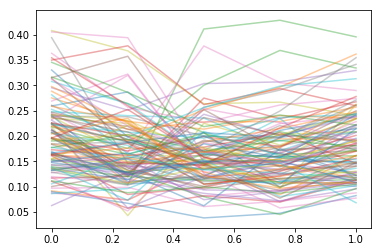

In [507]:
f,ax = plt.subplots()
im = ax.plot(m,meanrates_same[:,:].T,alpha=.4)

In [ ]:
# sub divide into 0 greater than 1, and 1 greater than 0

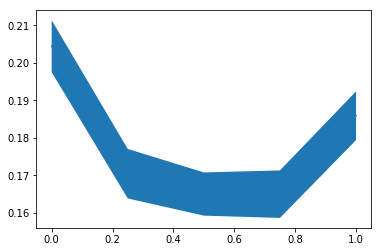

In [510]:
f,ax = plt.subplots()
mu,sem = meanrates_same.mean(axis=0), sp.stats.sem(meanrates_same,axis=0)
ax.plot(m,meanrates_same.mean(axis=0))
ax.fill_between(m,mu-sem,mu+sem)

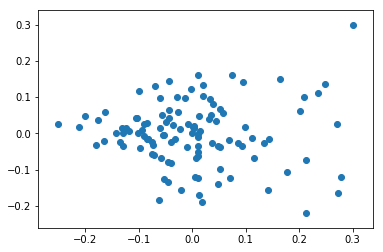

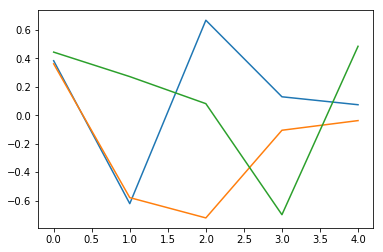

In [514]:
pca = sk.decomposition.PCA()
lv = pca.fit_transform(meanrates_same)
f,ax = plt.subplots()
ax.scatter(lv[:,0],lv[:,1])
f,ax = plt.subplots()
ax.plot(pca.components_[:,:3])

In [496]:
# take an example place cell
PCs_0 = S_trial_mat_sort[:,:,ex_mask1]
print(PCs_0.shape)
ratemaps0 = PCs_0[morphssort==1,:,:]

bsmeanrm0 = np.zeros(ratemaps0.shape[1:])
ntrials = ratemaps0.shape[0]
for i in range(20):
    inds = np.random.permutation(ntrials)
    inds = inds[:int(ntrials*.5)]
    bsmeanrm0 += ratemaps0[inds,:,:].mean(axis=0)
bsmeanrm0/=20

# bsmeanrm0 = np.median(ratemaps0,axis=0)
    

# highlight "place field" 
maxpos = np.argmax(bsmeanrm0,axis=0)
print(maxpos.shape)
minb = np.maximum(0,maxpos-5)
maxb = np.minimum(45,maxpos+5)
print(minb.shape,maxb.shape)




# look at normalized firing rate across morphs


(100, 45, 258)
(258,)
(258,) (258,)


(5, 45, 258)


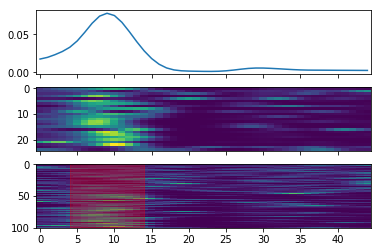

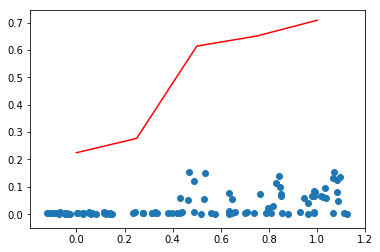

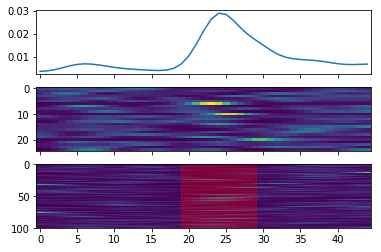

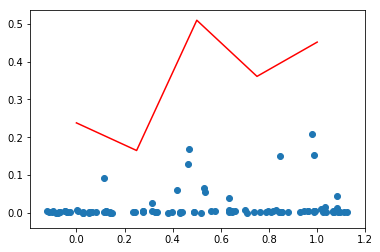

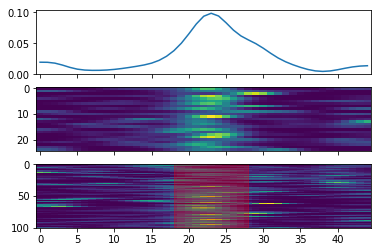

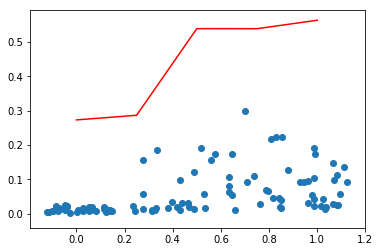

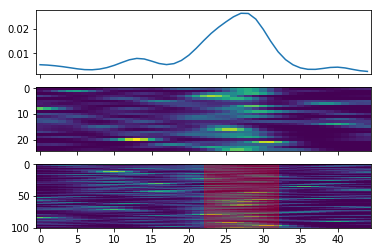

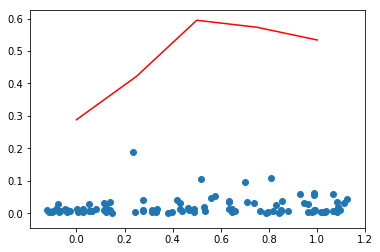

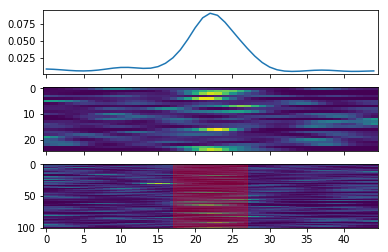

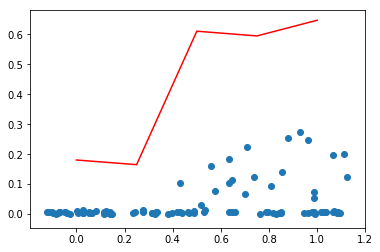

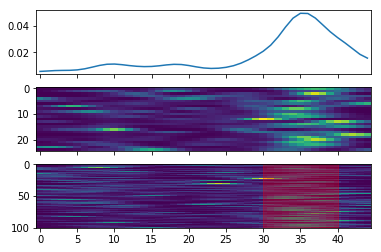

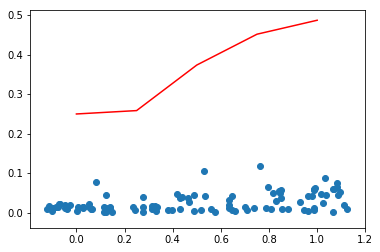

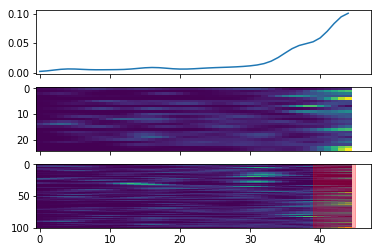

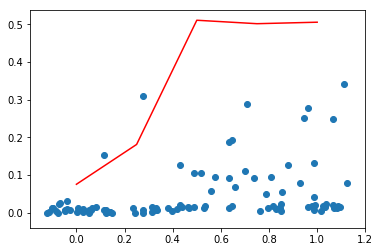

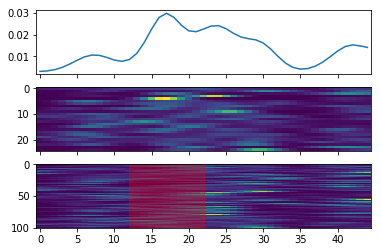

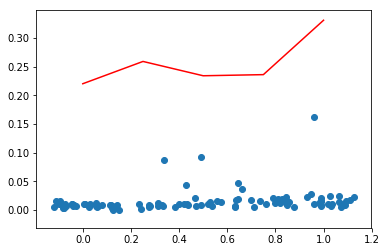

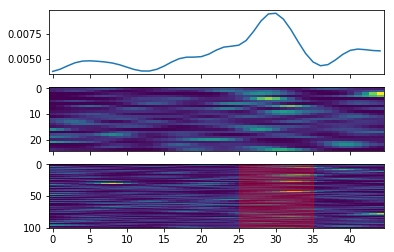

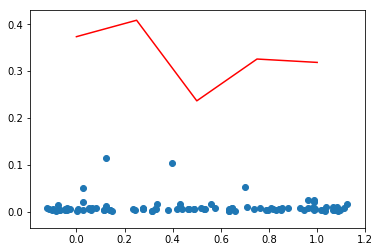

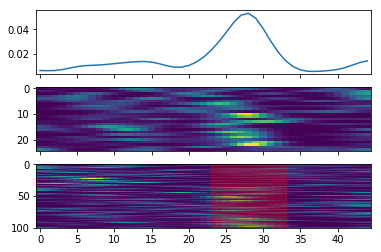

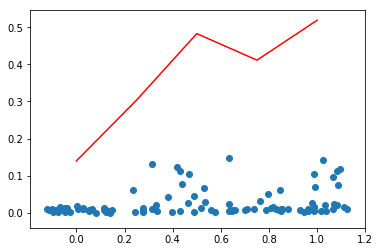

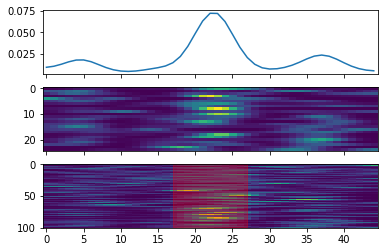

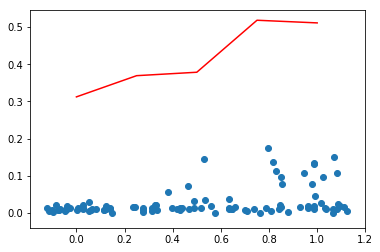

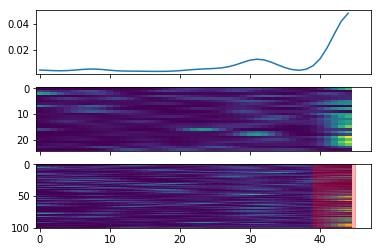

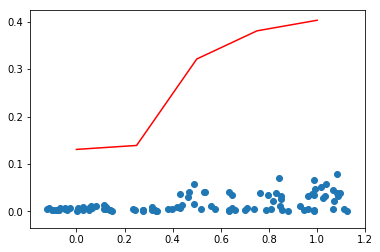

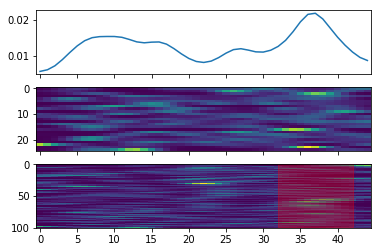

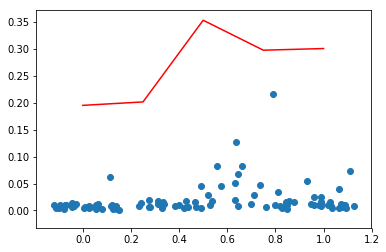

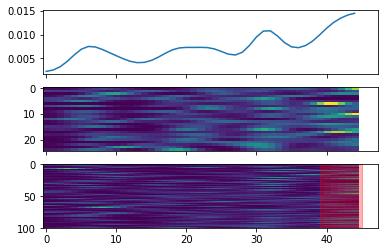

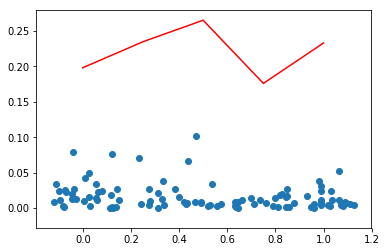

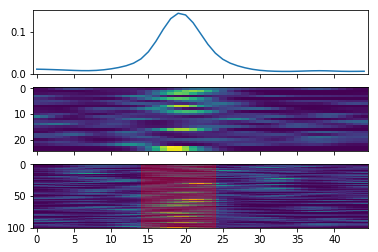

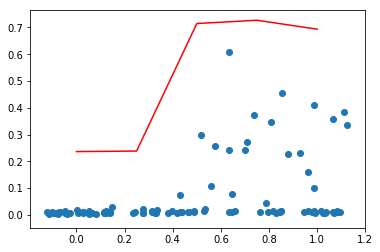

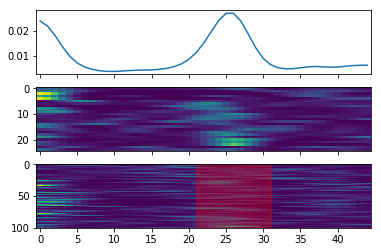

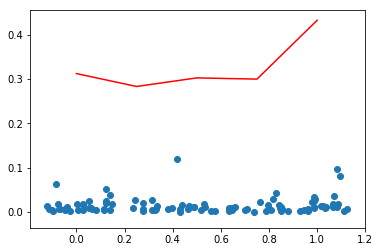

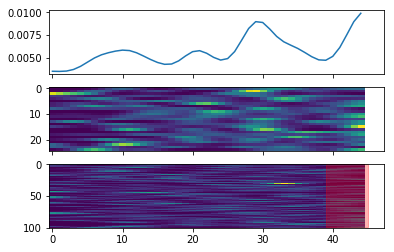

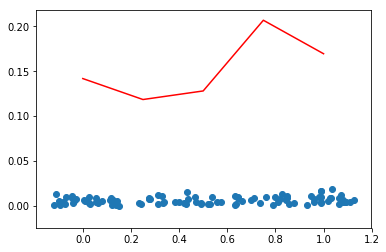

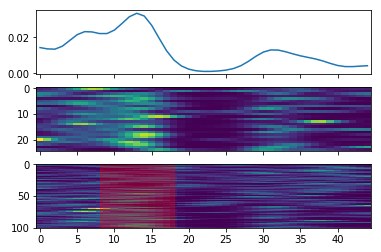

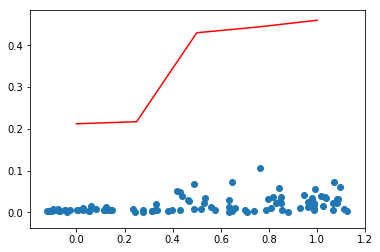

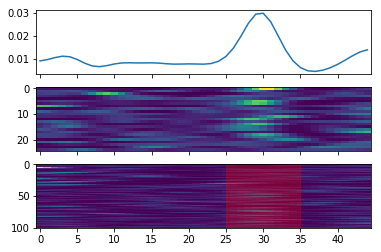

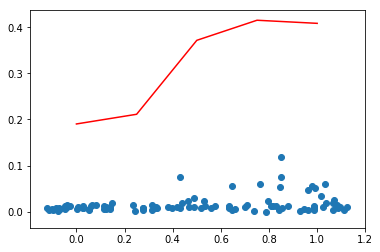

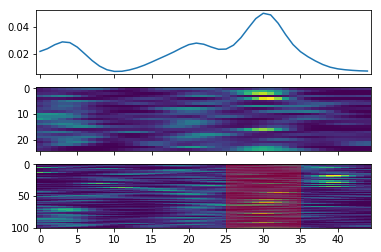

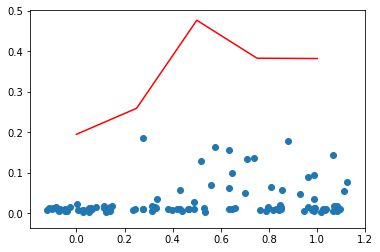

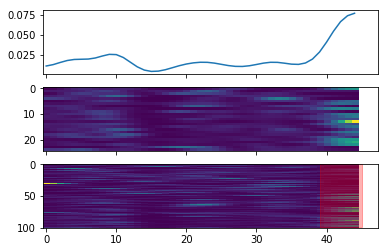

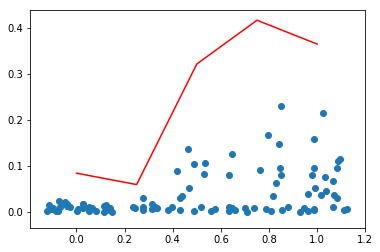

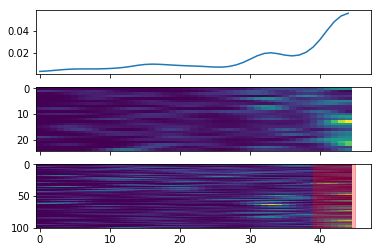

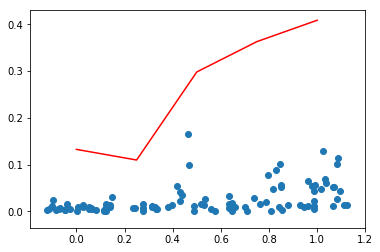

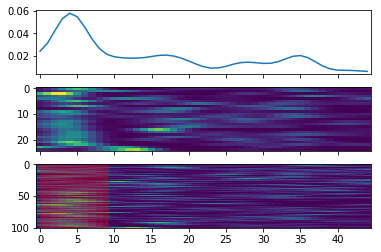

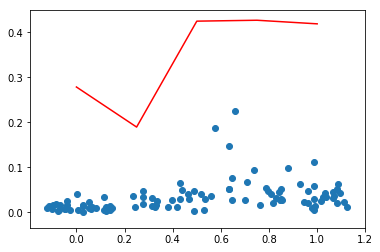

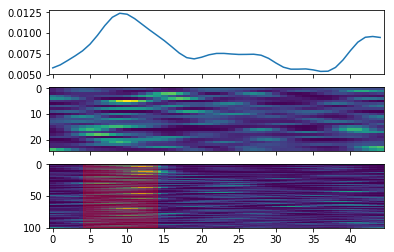

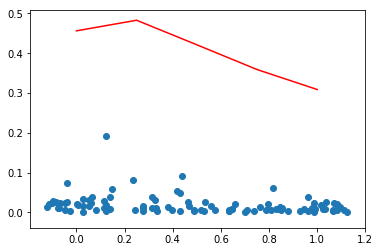

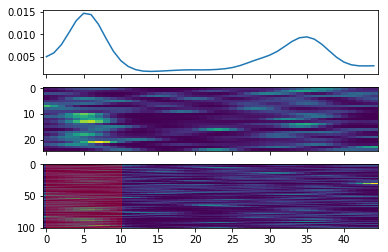

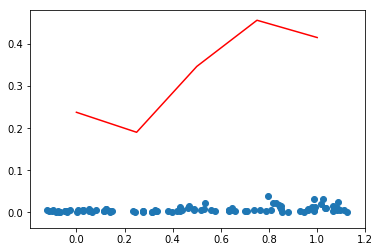

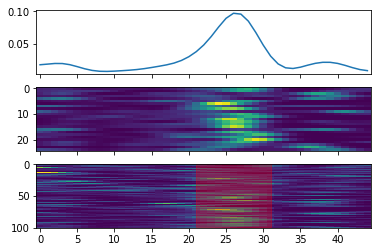

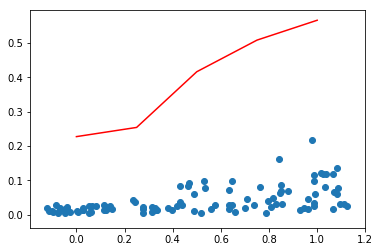

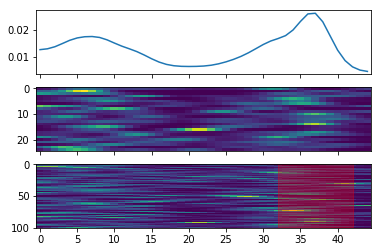

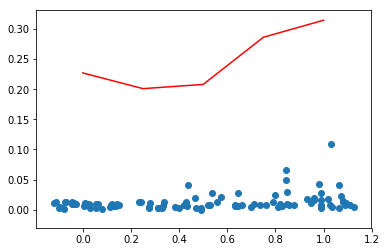

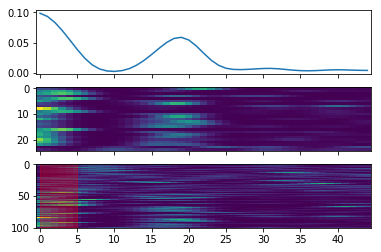

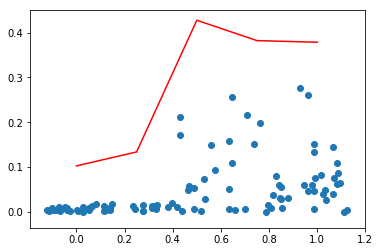

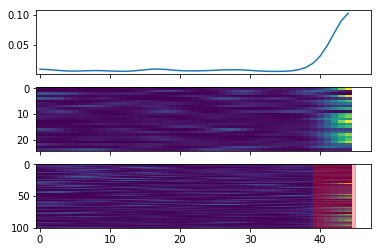

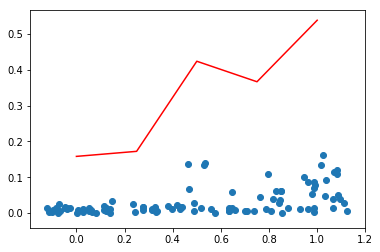

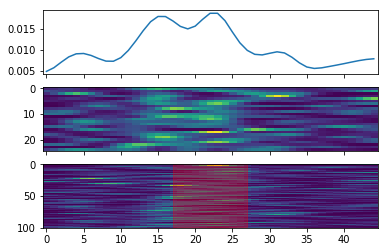

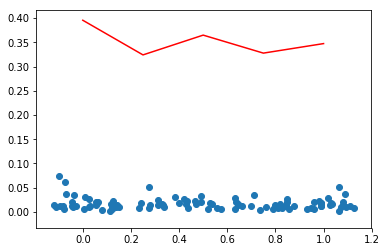

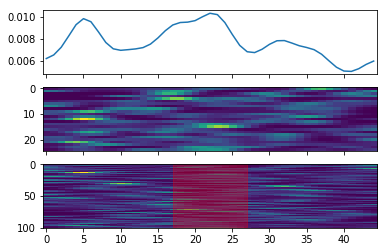

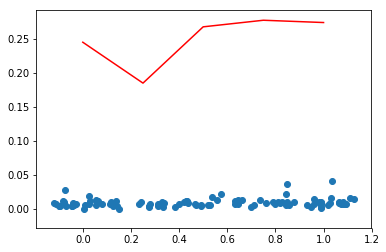

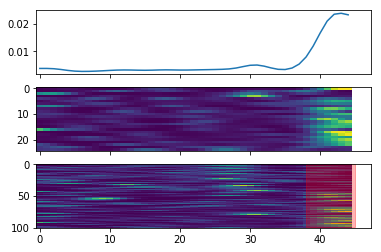

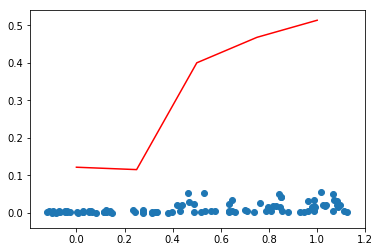

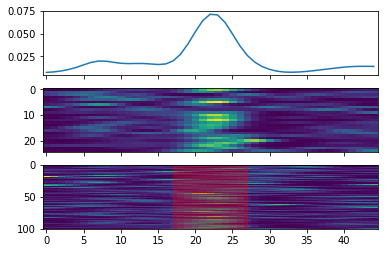

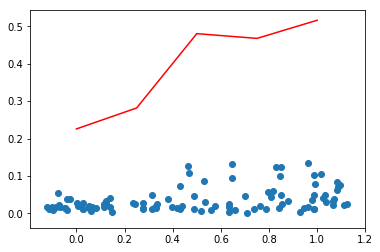

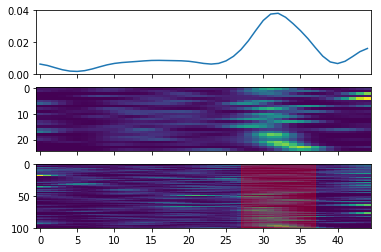

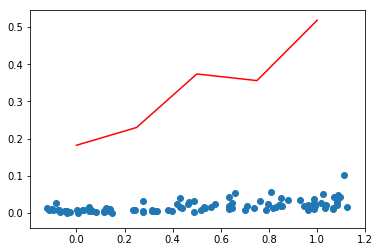

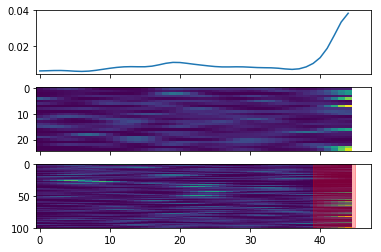

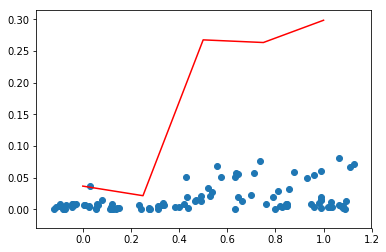

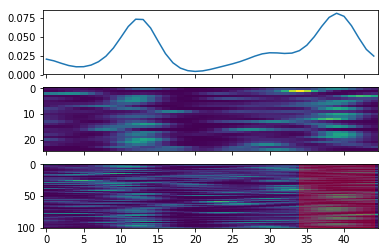

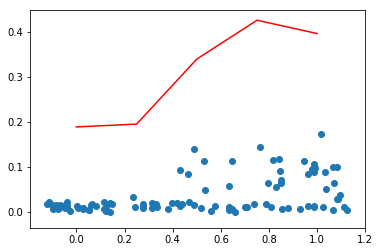

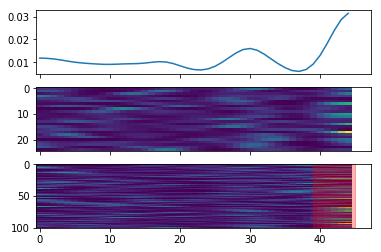

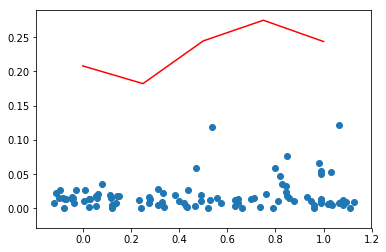

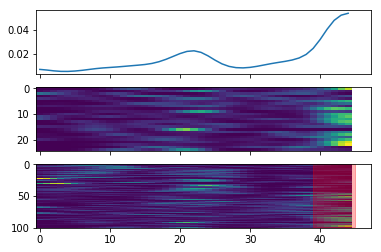

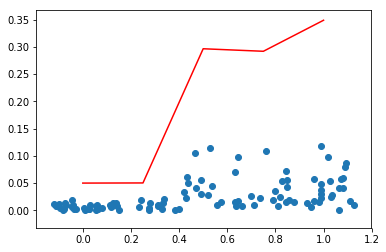

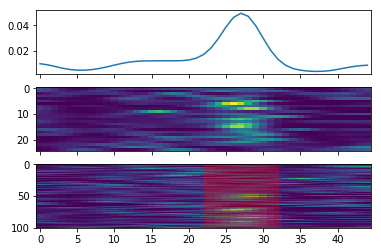

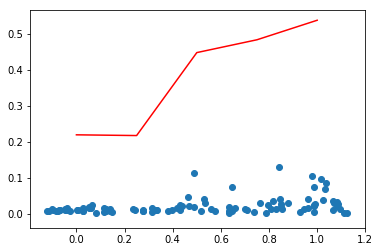

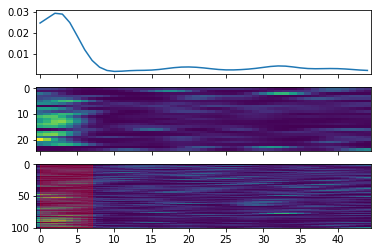

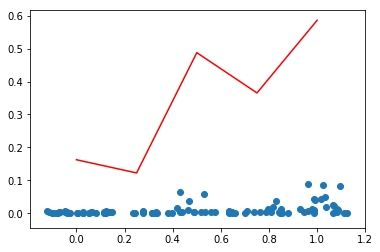

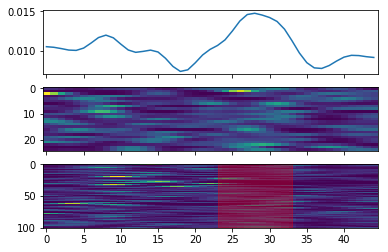

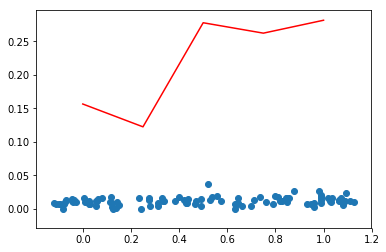

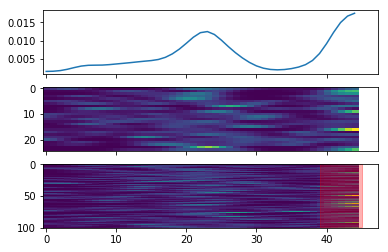

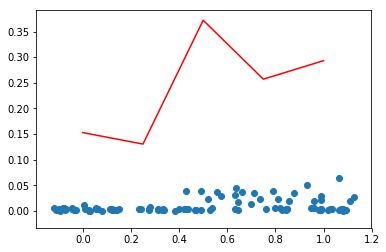

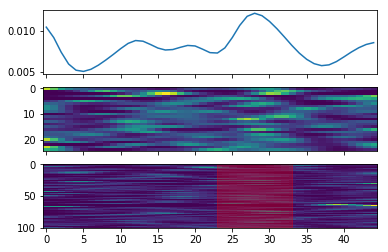

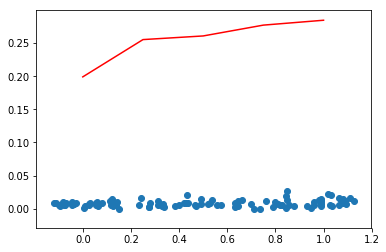

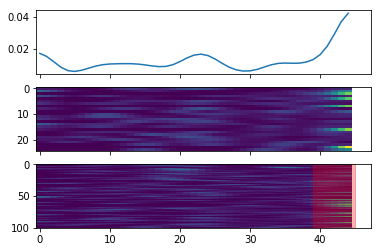

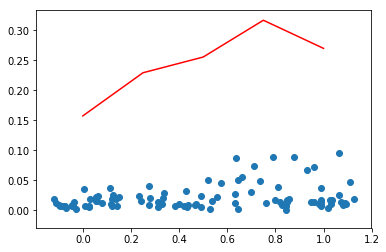

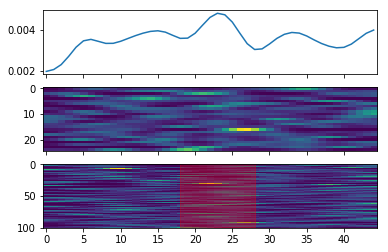

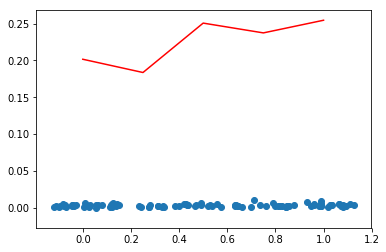

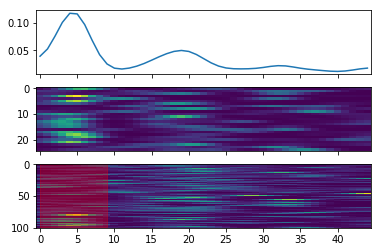

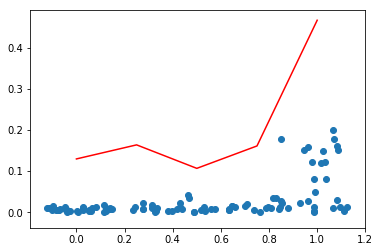

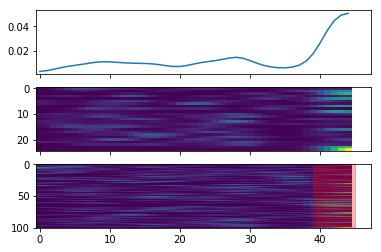

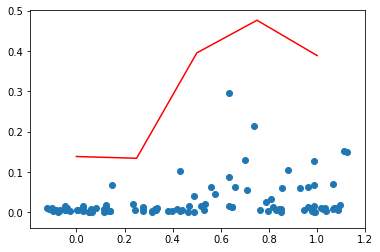

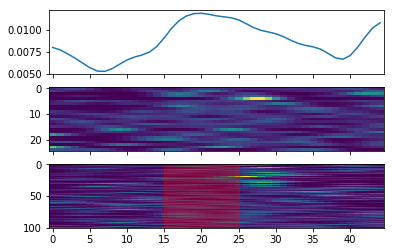

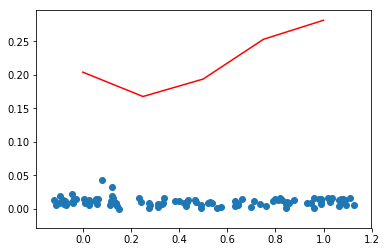

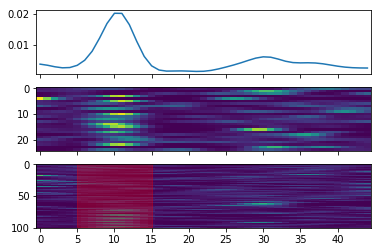

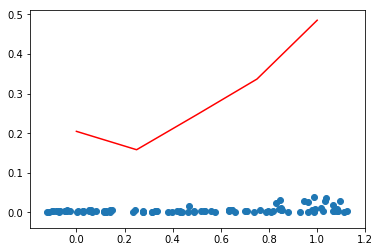

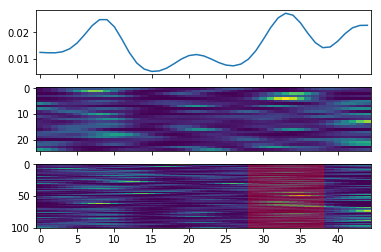

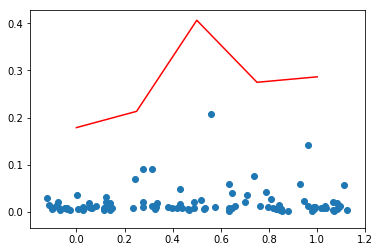

In [497]:
avgMat,trsh = u.across_trial_avg(PCs_0,morphssort)
print(avgMat.shape)
meanrates0 = np.zeros([PCs_0.shape[-1],5])
rates0 = np.zeros([PCs_0.shape[-1],S_trial_mat.shape[0]])
for c in range(PCs_0.shape[-1]):
    rates0[c,:]=PCs_0[:,minb[c]:maxb[c],c].mean(axis=1)#/(PCs_0[:,:,c].sum(axis=1)-PCs_0[:,minb[c]:maxb[c],c].sum(axis=1))*34
    meanrates0[c,:]=avgMat[:,minb[c]:maxb[c],c].sum(axis=1)/(avgMat[:,:,c].sum(axis=1)) #-avgMat[:,minb[c]:maxb[c],c].sum(axis=1))
    


# basis = u.make_spline_basis(effMorph_sort)
# print(basis.shape)
# mdl = sk.linear_model.LinearRegression()
# mdl.fit(basis,rates0.T)

# Y = mdl.predict(u.make_spline_basis(np.linspace(.1,.9)))



for c in range(50): #PCs_0.shape[-1]):
#     spl = sp.interpolate.UnivariateSpline(effMorph_sort,rates0[c,:])
    
    f,ax = plt.subplots(3,1,sharex=True,sharey=False)
    ax[0].plot(bsmeanrm0[:,c])
#     f,ax=plt.subplots()
    ax[1].imshow(ratemaps0[:,:,c]/ratemaps0[:,:,c].sum(axis=1)[:,np.newaxis],aspect='auto')
    ax[2].imshow(PCs_0[:,:,c]/PCs_0[:,:,c].sum(axis=1)[:,np.newaxis],aspect='auto')
    ax[2].fill_betweenx(np.arange(0,S_trial_mat.shape[0]),x1=minb[c],x2=maxb[c],alpha=.3,color='red')

    f,ax = plt.subplots()
    ax.scatter(effMorph_sort,rates0[c,:])
    ax.plot([0,.25,.5,.75,1],meanrates0[c,:],color='red')
#     ax.plot(np.linspace(.1,.9),Y[:,c],color='red')
#     xspl = np.linspace(effMorph_sort[0],effMorph_sort[-1])
#     ax.plot(xspl,spl(xspl),color='red')

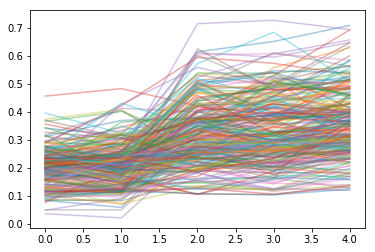

In [501]:
f,ax = plt.subplots()
n0 = meanrates0[:,0]
meanrates0n = meanrates0#np.sum(meanrates0,axis=1)[:,np.newaxis]
im = ax.plot(meanrates0n[:,:].T,alpha=.4)

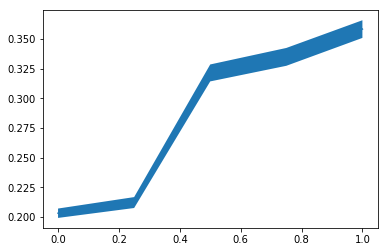

In [502]:
f,ax = plt.subplots()
m = [0,.25,.5,.75,1]
mu0n,sem0n = meanrates0n.mean(axis=0), sp.stats.sem(meanrates0n,axis=0)
ax.plot(m,meanrates0n.mean(axis=0))
ax.fill_between(m,mu0n-sem0n,mu0n+sem0n)